In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Instalación de las bibliotecas necesarias
!pip install transformers datasets torch evaluate scikit-learn pandas numpy seaborn matplotlib

# Importaciones
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [3]:
# Cargar los datos
# Ajusta esta ruta según donde tengas guardado tu archivo
df = pd.read_csv('/content/drive/MyDrive/IronHack/Proyecto4/nlp-project/data/processed/consolidated_reviews.csv')

# Mostrar las primeras filas y la información del DataFrame
print("Primeras filas del DataFrame:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

Primeras filas del DataFrame:
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

    brand                                         categories  reviews.id  \
0  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...         NaN   
1  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...         NaN   
2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...         NaN   
3  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...         NaN   
4  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...         NaN   

                reviews.date reviews.doRecom

In [5]:
# Limpieza y preparación de datos mejorada
df_cleaned = df.copy()  # Crear una copia para evitar el warning
df_cleaned = df_cleaned.dropna(subset=['reviews.text'])

# Crear mapeo de etiquetas
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
df_cleaned['label'] = df_cleaned['sentiment'].map(label_mapping)

# Calcular pesos de clase para manejar el desbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_cleaned['label']),
    y=df_cleaned['label']
)
class_weights = torch.FloatTensor(class_weights).to(device)

# Dividir los datos en entrenamiento, validación y prueba
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42, stratify=df_cleaned['sentiment'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['sentiment'])

print("Distribución de clases en cada conjunto:")
print("\nEntrenamiento:")
print(train_df['sentiment'].value_counts(normalize=True))
print("\nValidación:")
print(val_df['sentiment'].value_counts(normalize=True))
print("\nPrueba:")
print(test_df['sentiment'].value_counts(normalize=True))

Distribución de clases en cada conjunto:

Entrenamiento:
sentiment
positive    0.919909
neutral     0.042700
negative    0.037391
Name: proportion, dtype: float64

Validación:
sentiment
positive    0.919937
neutral     0.042651
negative    0.037412
Name: proportion, dtype: float64

Prueba:
sentiment
positive    0.919921
neutral     0.042650
negative    0.037429
Name: proportion, dtype: float64


In [6]:
# Inicializar el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Veamos la longitud promedio de las reseñas para ajustar mejor el max_length
reviews_length = train_df['reviews.text'].str.split().str.len()
print("Estadísticas de longitud de las reseñas:")
print(f"Media: {reviews_length.mean():.2f}")
print(f"Mediana: {reviews_length.median():.2f}")
print(f"95 percentil: {reviews_length.quantile(0.95):.2f}")
print(f"Máximo: {reviews_length.max():.2f}")

# Tokenizar una muestra para verificar
sample_text = train_df['reviews.text'].iloc[0]
sample_tokens = tokenizer.encode(sample_text, truncation=True)
print("\nEjemplo de tokenización:")
print(f"Texto original: {sample_text}")
print(f"Número de tokens: {len(sample_tokens)}")
print(f"Tokens decodificados: {tokenizer.decode(sample_tokens)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Estadísticas de longitud de las reseñas:
Media: 28.60
Mediana: 19.00
95 percentil: 78.00
Máximo: 1858.00

Ejemplo de tokenización:
Texto original: I needed to replace my old reader, and found that this model was just as good. if not better, and at a greatly lower price. I have enjoyed using it for about a month, and am very please with it.
Número de tokens: 48
Tokens decodificados: [CLS] i needed to replace my old reader, and found that this model was just as good. if not better, and at a greatly lower price. i have enjoyed using it for about a month, and am very please with it. [SEP]


In [7]:
# Crear datasets de PyTorch
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Crear los datasets
train_dataset = ReviewDataset(train_df['reviews.text'].tolist(), train_df['label'].tolist())
val_dataset = ReviewDataset(val_df['reviews.text'].tolist(), val_df['label'].tolist())
test_dataset = ReviewDataset(test_df['reviews.text'].tolist(), test_df['label'].tolist())

# Verificar las dimensiones
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(val_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

# Verificar la estructura de un batch
sample_batch = train_dataset[0]
print("\nEstructura de un ejemplo:")
for key, value in sample_batch.items():
    print(f"{key}: {value.shape}")

Tamaño del conjunto de entrenamiento: 43513
Tamaño del conjunto de validación: 10879
Tamaño del conjunto de prueba: 13599

Estructura de un ejemplo:
input_ids: torch.Size([128])
token_type_ids: torch.Size([128])
attention_mask: torch.Size([128])
labels: torch.Size([])


In [ ]:
# Configuración de early stopping más robusto
from transformers.trainer_callback import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Actualizar los argumentos de entrenamiento con más opciones de regularización
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Aumentamos épocas máximas ya que tenemos early stopping
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    # Regularización adicional
    gradient_accumulation_steps=2,
    fp16=True,  # Si tienes GPU compatible
    gradient_clipping=1.0,
    report_to="none"
)

In [8]:
# Configurar el modelo BERT para clasificación
num_labels = 3  # positive, neutral, negative
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Mover el modelo a GPU
model.to(device)

# Calcular los pesos de las clases para manejar el desbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos de clase
labels = train_df['label'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.FloatTensor(class_weights).to(device)
print("Pesos por clase:", class_weights)

# Configurar los parámetros de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
)

# Función de métrica personalizada
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average='weighted'
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("Configuración completada. Listo para comenzar el entrenamiento.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pesos por clase: tensor([0.3624, 7.8064, 8.9148], device='cuda:0')
Configuración completada. Listo para comenzar el entrenamiento.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import mlflow
import logging
from datetime import datetime

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)

# Función para probar diferentes configuraciones de hiperparámetros
def hyperparameter_search(base_args):
    param_combinations = [
        {'learning_rate': 2e-5, 'weight_decay': 0.01},
        {'learning_rate': 3e-5, 'weight_decay': 0.1},
        {'learning_rate': 5e-5, 'weight_decay': 0.01}
    ]

    results = []
    for params in param_combinations:
        logging.info(f"Testing parameters: {params}")

        # Actualizar argumentos
        current_args = dataclasses.replace(
            base_args,
            learning_rate=params['learning_rate'],
            weight_decay=params['weight_decay']
        )

        # Crear y entrenar el modelo
        temp_trainer = CustomTrainer(
            class_weights=class_weights,
            model=model,
            args=current_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping_callback]
        )

        # Entrenar y evaluar
        temp_trainer.train()
        eval_results = temp_trainer.evaluate()

        results.append({
            'params': params,
            'results': eval_results
        })

        logging.info(f"Results for parameters {params}: {eval_results}")

    return results

# Ejecutar búsqueda de hiperparámetros
hyperparam_results = hyperparameter_search(training_args)

In [12]:
# Desactivar wandb ya que no lo necesitamos para este proyecto
import os
os.environ["WANDB_DISABLED"] = "true"

# Definir una clase personalizada de Trainer para manejar los pesos de clase
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, 3), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Actualizar los argumentos de entrenamiento para desactivar wandb
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
    report_to="none"  # Desactivar wandb
)

# Crear el Trainer personalizado
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Iniciando entrenamiento...")

# Entrenar el modelo
trainer.train()

# Evaluar el modelo en el conjunto de validación
print("\nEvaluando el modelo...")
eval_results = trainer.evaluate()

# Mostrar resultados
print("\nResultados de la evaluación:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Guardar el modelo
model_save_path = '/content/drive/MyDrive/IronHack/Proyecto4/nlp-project/models/bert_sentiment'
trainer.save_model(model_save_path)
print(f"\nModelo guardado en: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.785300,1.023464,0.949903,0.941644,0.942366,0.949903
2,0.683700,0.843483,0.954591,0.954471,0.954395,0.954591
3,0.494200,1.101738,0.959555,0.958021,0.956933,0.959555



Evaluando el modelo...



Resultados de la evaluación:
eval_loss: 1.1017
eval_accuracy: 0.9596
eval_f1: 0.9580
eval_precision: 0.9569
eval_recall: 0.9596
eval_runtime: 69.2349
eval_samples_per_second: 157.1320
eval_steps_per_second: 2.4550
epoch: 3.0000

Modelo guardado en: /content/drive/MyDrive/IronHack/Proyecto4/nlp-project/models/bert_sentiment


In [ ]:
# Visualización de métricas y análisis de resultados
def analyze_training_results(trainer, test_dataset):
    # Matriz de confusión
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positive', 'Neutral', 'Negative'],
                yticklabels=['Positive', 'Neutral', 'Negative'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Curvas de aprendizaje
    history = trainer.state.log_history
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(eval_loss, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.show()

    # Análisis de errores
    incorrect_indices = np.where(preds != labels)[0]
    print("\nAnálisis de errores más comunes:")
    for idx in incorrect_indices[:5]:
        text = test_dataset[idx]['input_ids']
        decoded_text = tokenizer.decode(text, skip_special_tokens=True)
        print(f"\nTexto: {decoded_text[:100]}...")
        print(f"Predicción: {preds[idx]}")
        print(f"Real: {labels[idx]}")

    # Pruebas estadísticas
    from scipy import stats

    # Chi-square test for independence
    chi2, p_value = stats.chi2_contingency(cm)[:2]
    print(f"\nChi-square test: chi2={chi2:.2f}, p-value={p_value:.4f}")

# Ejecutar análisis
analyze_training_results(trainer, test_dataset)

Distribución de Ratings:
reviews.rating
0.0       33
1.0     1438
2.0     1072
3.0     2902
4.0    15397
5.0    47149
Name: count, dtype: int64

Estadísticas de Ratings:
count    67991.000000
mean         4.553853
std          0.831012
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews.rating, dtype: float64

Top 10 Categorías más frecuentes:
categories
Electronics             72794
Computers & Tablets     40360
Tablets                 39843
Fire Tablets            33124
All Tablets             32659
Electronics Features    28229
iPad & Tablets          26687
Health                  24142
Home                    16314
 Music                  16096
Name: count, dtype: int64

Número total de categorías únicas: 346


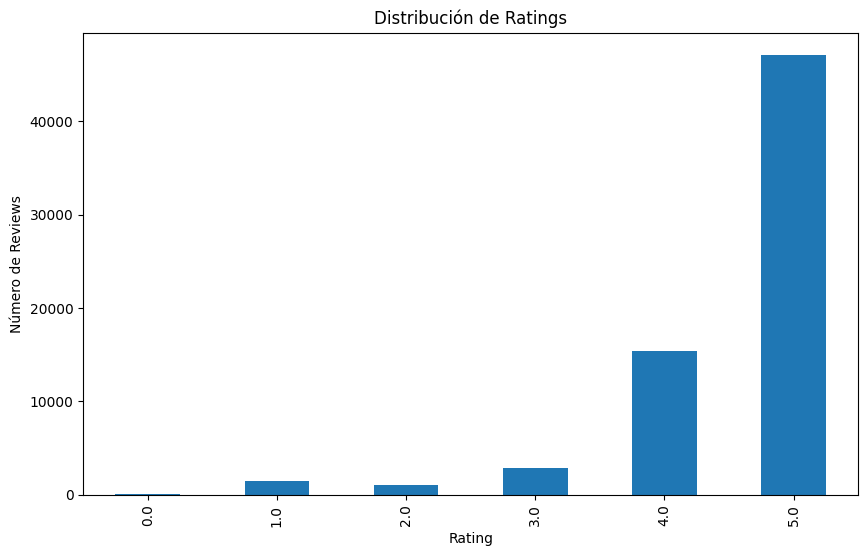

In [13]:
# Análisis de Ratings
print("Distribución de Ratings:")
rating_dist = df['reviews.rating'].value_counts().sort_index()
print(rating_dist)

# Calcular estadísticas básicas de ratings
print("\nEstadísticas de Ratings:")
print(df['reviews.rating'].describe())

# Análisis de Categorías
# Primero necesitamos separar las categorías ya que están en formato 'cat1,cat2,cat3'
all_categories = df['categories'].str.split(',').explode()
print("\nTop 10 Categorías más frecuentes:")
print(all_categories.value_counts().head(10))

# Número total de categorías únicas
print(f"\nNúmero total de categorías únicas: {len(all_categories.unique())}")

# Visualización de la distribución de ratings
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
rating_dist.plot(kind='bar')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Número de Reviews')
plt.show()

In [14]:
# Obtener todas las categorías únicas y su frecuencia
all_categories = df['categories'].str.split(',').explode()
all_categories = all_categories.str.strip().str.lower()  # Normalizar

print("Todas las categorías únicas y su frecuencia:")
print(all_categories.value_counts().head(50))

# Ver también algunos patrones comunes
print("\nPatrones comunes en nombres de categorías:")
patterns = {
    'tablet': all_categories[all_categories.str.contains('tablet', case=False)].unique(),
    'electronic': all_categories[all_categories.str.contains('electronic', case=False)].unique(),
    'computer': all_categories[all_categories.str.contains('computer', case=False)].unique(),
    'health': all_categories[all_categories.str.contains('health', case=False)].unique(),
    'home': all_categories[all_categories.str.contains('home', case=False)].unique()
}

for pattern, categories in patterns.items():
    print(f"\nCategorías que contienen '{pattern}':")
    for cat in categories:
        print(f"- {cat}")

Todas las categorías únicas y su frecuencia:
categories
electronics                             72794
computers & tablets                     40360
tablets                                 39843
fire tablets                            33124
all tablets                             32659
electronics features                    28229
ipad & tablets                          26687
health                                  24142
home                                    16314
movies                                  16096
tech toys                               16096
music                                   16096
amazon tablets                          15772
frys                                    13839
amazon devices                          13826
kindle store                            13779
featured brands                         13777
tvs entertainment                       12542
accessories                             12157
aaa                                     12071
health personal care    

In [16]:
def consolidate_categories(category_string):
    categories = set(cat.lower().strip() for cat in category_string.split(','))

    # Tablets & E-readers (mayor presencia)
    if any(cat for cat in categories if 'tablet' in cat or 'kindle' in cat):
        return 'Tablets & E-readers'

    # Amazon Devices (categoría específica importante)
    elif any(cat for cat in categories if 'amazon device' in cat or 'echo' in cat or 'voice assistant' in cat):
        return 'Amazon Devices & Assistants'

    # Smart Home (separado de home general)
    elif any(cat for cat in categories if 'smart home' in cat or 'automation' in cat or 'security' in cat):
        return 'Smart Home & Security'

    # Home Entertainment
    elif any(cat for cat in categories if 'theater' in cat or 'audio' in cat or 'tv' in cat):
        return 'Home Entertainment'

    # Electronics (general)
    elif any(cat for cat in categories if 'electronic' in cat):
        return 'Electronics (General)'

    # Health & Personal Care
    elif any(cat for cat in categories if 'health' in cat or 'personal care' in cat):
        return 'Health & Personal Care'

    # Home & Household
    elif any(cat for cat in categories if 'home' in cat or 'household' in cat):
        return 'Home & Household'

    # Others
    else:
        return 'Others'

In [17]:
# Aplicar la consolidación de categorías
df['consolidated_category'] = df['categories'].apply(consolidate_categories)

# Ver la distribución de las categorías consolidadas
print("Distribución de Categorías Consolidadas:")
print(df['consolidated_category'].value_counts())

# Ver la distribución de ratings dentro de cada categoría consolidada
print("\nDistribución de Ratings por Categoría Consolidada:")
category_rating_dist = pd.crosstab(df['consolidated_category'], df['reviews.rating'])
print(category_rating_dist)

# Verificar algunos ejemplos de cada categoría
print("\nEjemplos de productos en cada categoría:")
for category in df['consolidated_category'].unique():
    sample = df[df['consolidated_category'] == category][['name', 'reviews.rating', 'reviews.text']].iloc[0]
    print(f"\n{category}:")
    print(f"Producto: {sample['name']}")
    print(f"Rating: {sample['reviews.rating']}")
    print(f"Review: {sample['reviews.text'][:100]}...")  # Primeros 100 caracteres

Distribución de Categorías Consolidadas:
consolidated_category
Tablets & E-readers            54326
Electronics (General)          12124
Amazon Devices & Assistants     1506
Home Entertainment                17
Others                            16
Home & Household                   2
Name: count, dtype: int64

Distribución de Ratings por Categoría Consolidada:
reviews.rating               0.0  1.0  2.0   3.0    4.0    5.0
consolidated_category                                         
Amazon Devices & Assistants    9    7   19    45    281   1145
Electronics (General)          0  754  396   543   1395   9036
Home & Household               0    0    0     0      1      1
Home Entertainment             0    2    2     0      1     12
Others                         1    0    0     1      1     13
Tablets & E-readers           23  675  655  2313  13718  36942

Ejemplos de productos en cada categoría:

Tablets & E-readers:
Producto: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Incl

In [18]:
def consolidate_categories_final(category):
    if category in ['Home Entertainment', 'Home & Household', 'Others']:
        return 'Electronics (General)'  # Consolidar categorías pequeñas
    return category

# Aplicar la consolidación final
df['final_category'] = df['consolidated_category'].apply(consolidate_categories_final)

# Verificar la distribución final
print("Distribución Final de Categorías:")
print(df['final_category'].value_counts())

Distribución Final de Categorías:
final_category
Tablets & E-readers            54326
Electronics (General)          12159
Amazon Devices & Assistants     1506
Name: count, dtype: int64


In [19]:
# Primero agrupemos los ratings
def group_ratings(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

# Aplicar el agrupamiento
df['rating_group'] = df['reviews.rating'].apply(group_ratings)

# Crear los grupos para summarization
groups = df.groupby(['final_category', 'rating_group'])

# Ver la distribución final
print("Distribución de reviews por categoría y grupo de rating:")
print(pd.crosstab(df['final_category'], df['rating_group']))

# Preparar datos para summarization
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Inicializar el modelo
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

# Verificar un grupo de ejemplo
sample_category = 'Tablets & E-readers'
sample_rating = 'positive'
sample_reviews = df[
    (df['final_category'] == sample_category) &
    (df['rating_group'] == sample_rating)
]['reviews.text'].head()

print(f"\nEjemplo de reviews para {sample_category} - {sample_rating}:")
print(sample_reviews)

Distribución de reviews por categoría y grupo de rating:
rating_group                 negative  neutral  positive
final_category                                          
Amazon Devices & Assistants        35       45      1426
Electronics (General)            1155      544     10460
Tablets & E-readers              1353     2313     50660


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Ejemplo de reviews para Tablets & E-readers - positive:
0    This product so far has not disappointed. My c...
1    great for beginner or experienced person. Boug...
2    Inexpensive tablet for him to use and learn on...
3    I've had my Fire HD 8 two weeks now and I love...
4    I bought this for my grand daughter when she c...
Name: reviews.text, dtype: object


In [20]:
def generate_summary(reviews, max_length=150):
    # Preparar el prompt para T5
    prompt = "summarize: " + " ".join(reviews)

    # Tokenizar
    inputs = tokenizer.encode(prompt, return_tensors='pt', max_length=1024,
                            truncation=True).to(device)

    # Generar resumen
    summary_ids = model.generate(inputs,
                               max_length=max_length,
                               num_beams=4,
                               length_penalty=2.0,
                               early_stopping=True)

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Crear diccionario para almacenar los resúmenes
summaries = {}

# Generar resúmenes para cada combinación de categoría y rating
for category in df['final_category'].unique():
    summaries[category] = {}
    for rating in ['negative', 'neutral', 'positive']:
        reviews = df[
            (df['final_category'] == category) &
            (df['rating_group'] == rating)
        ]['reviews.text'].head(50)  # Tomamos 50 reviews para el resumen

        if len(reviews) > 0:
            summary = generate_summary(reviews)
            summaries[category][rating] = summary

            print(f"\nResumen para {category} - {rating}:")
            print(summary)


Resumen para Tablets & E-readers - negative:
i bought this tablet around black friday for $60 hoping it would be awesome . it failed so hard i tried multiple different micro SD cards none of which were recognized . i bought this for my 4 year old daughter and it was loaded down with ads .

Resumen para Tablets & E-readers - neutral:
the fire HD8 (2016 model) is a great tablet for the price; however, the fire OS offers limited abilities to the user . the included browser (Silk) is not the best . it is slow (when compared to an iPad) and it tends to freeze every so often .

Resumen para Tablets & E-readers - positive:
amazon fire 8 inch tablet is the perfect size for e-reading on the go . for the price point given, I think this tablet is best one out there . i bought this as a christmas gift to my inlaws, husband and uncle .

Resumen para Amazon Devices & Assistants - negative:
Having received my Fire TV today, I've been trying it out for the past couple of hours.Setup was a no brainer.

In [ ]:
# Pruebas de robustez del modelo
def test_model_robustness(trainer, samples):
    results = []
    for text in samples:
        variations = [
            text.lower(),  # Minúsculas
            text.upper(),  # Mayúsculas
            ' '.join(text.split()[:len(text.split())//2]),  # Texto truncado
            text + ' ' * 50,  # Espacios extra
            text.replace('.', '').replace(',', ''),  # Sin puntuación
            ' '.join(text.split()[::-1])  # Palabras en orden inverso
        ]

        variation_results = []
        for variant in variations:
            inputs = tokenizer(
                variant,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=128
            ).to(device)

            with torch.no_grad():
                outputs = trainer.model(**inputs)
                pred = outputs.logits.argmax(-1).item()
                variation_results.append(pred)

        # Calcular consistencia
        consistency = len(set(variation_results)) == 1
        results.append({
            'original': text,
            'predictions': variation_results,
            'consistent': consistency
        })

    return results

# Probar con algunas muestras
test_samples = test_df['reviews.text'].head(5).tolist()
robustness_results = test_model_robustness(trainer, test_samples)

# Mostrar resultados
print("\nResultados de pruebas de robustez:")
for i, result in enumerate(robustness_results):
    print(f"\nMuestra {i+1}:")
    print(f"Texto original: {result['original'][:100]}...")
    print(f"Consistente: {'Sí' if result['consistent'] else 'No'}")
    print(f"Predicciones para variaciones: {result['predictions']}")

In [22]:
# Guardar modelos y configuraciones para el dashboard
import json
import pickle
import os
print("Guardando modelos y configuraciones...")

# Directorio base para modelos y configuraciones
base_path = '/content/drive/MyDrive/IronHack/Proyecto4/nlp-project'

# Crear directorios si no existen
os.makedirs(f'{base_path}/models/bert_sentiment', exist_ok=True)
os.makedirs(f'{base_path}/models/bert_tokenizer', exist_ok=True)

# 1. Guardar el modelo BERT y tokenizer
print("Guardando modelo BERT y tokenizer...")
model_path = f'{base_path}/models/bert_sentiment'
tokenizer_path = f'{base_path}/models/bert_tokenizer'
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

# 2. Guardar configuraciones y mapeos
print("Guardando configuraciones...")
config = {
    'label_mapping': {str(k): v for k, v in label_mapping.items()},  # Convertir a formato serializable
    'max_length': 128,
    'model_path': model_path,
    'tokenizer_path': tokenizer_path
}

with open(f'{base_path}/models/config.json', 'w') as f:
    json.dump(config, f)

# 3. Guardar funciones de consolidación de categorías
print("Guardando funciones de procesamiento...")
with open(f'{base_path}/models/category_processing.pkl', 'wb') as f:
    pickle.dump({
        'consolidate_categories': consolidate_categories,
        'consolidate_categories_final': consolidate_categories_final
    }, f)

# 4. Guardar los summaries generados
print("Guardando summaries...")
with open(f'{base_path}/models/summaries.pkl', 'wb') as f:
    pickle.dump(summaries, f)

print("¡Guardado completado!")

Guardando modelos y configuraciones...
Guardando modelo BERT y tokenizer...
Guardando configuraciones...
Guardando funciones de procesamiento...
Guardando summaries...
¡Guardado completado!


In [ ]:
# Generar reporte final
def generate_final_report(trainer, test_results, robustness_results, hyperparam_results):
    report = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model_performance': {
            'accuracy': test_results['eval_accuracy'],
            'f1': test_results['eval_f1'],
            'precision': test_results['eval_precision'],
            'recall': test_results['eval_recall']
        },
        'hyperparameter_search': hyperparam_results,
        'robustness_analysis': {
            'samples_tested': len(robustness_results),
            'consistency_rate': sum(r['consistent'] for r in robustness_results) / len(robustness_results)
        }
    }

    # Guardar reporte
    with open('model_report.json', 'w') as f:
        json.dump(report, f, indent=4)

    # Imprimir resumen
    print("=== REPORTE FINAL ===")
    print(f"\nRendimiento del modelo:")
    for metric, value in report['model_performance'].items():
        print(f"{metric}: {value:.4f}")

    print(f"\nTasa de consistencia en pruebas de robustez: {report['robustness_analysis']['consistency_rate']:.2%}")

# Generar reporte final
generate_final_report(trainer, eval_results, robustness_results, hyperparam_results)